In [1]:
import re,os
import math
import shap
import pickle 
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from utils.dataset import dataset

from utils.tfidf import top_words
from utils.dataset import dataset
from utils.helpers import *

/usr/local/lib/python3.6/dist-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
description, df = dataset()


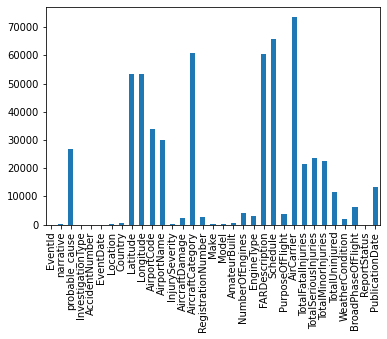

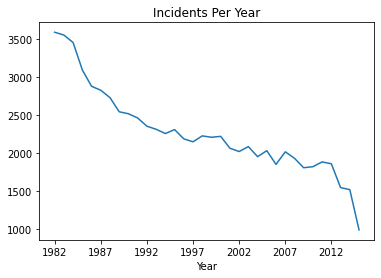

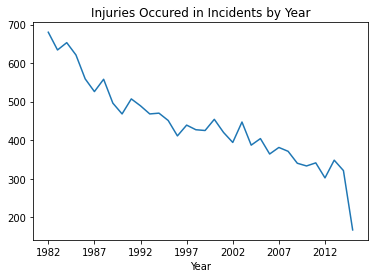

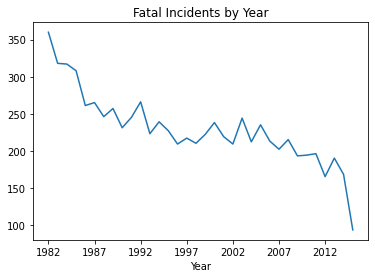

In [3]:
#plotting missing observations
description['blank_str'].plot(kind='bar')
plt.show()


#plotting incidents per year
#Incidents defined as unique EventIds in that year
IncYrPlot(df, 'Incidents Per Year')
plt.show()


#finding incidents with any severity of injury
inj_cols = [i for i in df.columns if 'Injuries' in i]
df_injuries = df[(df[inj_cols]>1).sum(axis=1)>=1]
#plotting incidents that contained injuries per year
IncYrPlot(df_injuries, 'Injuries Occured in Incidents by Year')
plt.show()


#finding incidents with fatalities
inj_cols = [i for i in df.columns if 'Fatal' in i]
fatal_injuries = df[(df[inj_cols]>1).sum(axis=1)>=1]
#plotting incidents with fatalities
IncYrPlot(fatal_injuries, 'Fatal Incidents by Year')
plt.show()

In [4]:
#fatal_rate is a function in util.helpers
#Big Airlines are determined by the AirCarrier field
#simple string matching filter for the word airlines in AirCarrier
#NotBig Airlines are obs missing AirCarrier or did not contain airlines
fatal_rate(df)

Total Big Airline Incidents: 1027 and their Fatal Incident Rate: 0.0759493670886076

Total NotBig Airline Incidents: 76224 and their Fatal Incident Rate: 0.20130142737195633



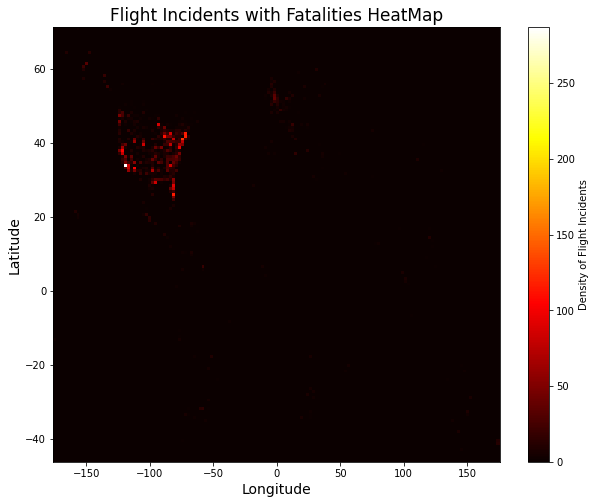

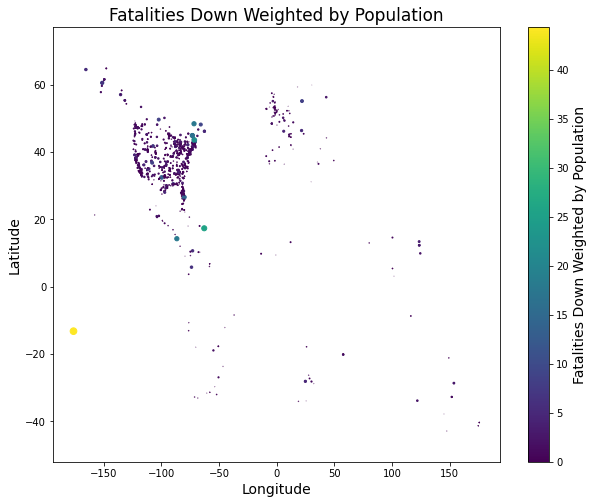

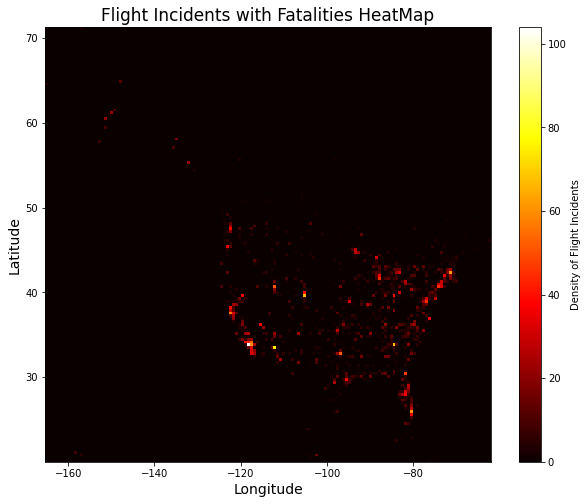

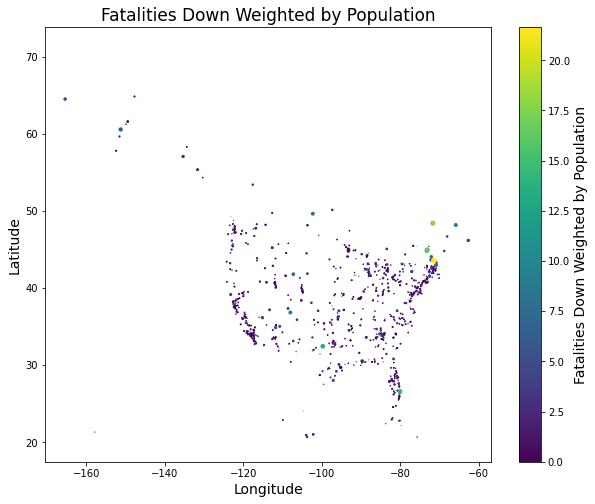

In [5]:
#latlongs reads the file geopoints.txt and populations.txt
#used fuzzy city/country matcher to find lat longs on Location field
#used a different api to find populations
#there an error associated with this that is not insignificant
lats, longs, us_mask, nonmissing_mask, scaled, pop_arr = latlongs(df)

#plots a heatmap of fatalities that occur in each city
#down weights fatalities that occur in large population areas
map_plots(longs,lats,scaled,us_mask)

In [6]:
#sums fatalities by city for just North America
north_am, world = fatal_locations(df, nonmissing_mask, pop_arr)
north_am

,Location,TotalFatalInjuries,pop,Scaled_Fatalities
1537,"gander, canada",256.0,540111.0,0.000474
3014,"new orleans, la",156.0,2284732.0,0.000068
4401,"washington, dc",78.0,941168.0,0.000083
2187,"la paz, bolivia",29.0,297554.0,0.000097
951,"covington, ky",23.0,320108.0,0.000072
...,...,...,...,...
2006,"jackson, ca",0.0,490748.0,0.000000
2007,"jackson, mi",0.0,245319.0,0.000000
2008,"jackson, ms",0.0,111694.0,0.000000
2009,"jackson, mt",0.0,190886.0,0.000000


In [7]:
#sum of fatalities by city & country in the world
world

,Location,TotalFatalInjuries
12111,"new delhi, india",698.0
15389,"sao paulo, brazil",317.0
943,"azevedo, brazil",308.0
7752,"hrabove, ukraine",295.0
8059,"islamabad, pakistan",284.0
...,...,...
10570,"maysville, wv",0.0
10571,"mayview, mo",0.0
10572,"mayville, nd",0.0
3249,"clara city, mn",0.0


In [8]:
#instantiate top_words class utils/tfidf.py
tw = top_words(df)

#find top words in the probable cause field for fatal and nonfatal incidents
fatal_words = tw.get_top_words(df, 'probable_cause', df['TotalFatalInjuries']>0, 100).keys()
nonfatal_words = tw.get_top_words(df, 'probable_cause', df['TotalFatalInjuries']==0, 100).keys()

print('Fatal Top Words\n\n',fatal_words,'\n\n\n\n','Non-Fatal Top Words\n\n',nonfatal_words)

Fatal Top Words

 dict_keys(['undetermined', 'suicide', 'pilot', 'windmill', 'aircraft missing', 'incapacitation pilot', 'suicide pilot', 'control pilot', 'powerlines']) 



 Non-Fatal Top Words

 dict_keys(['unknown', 'undetermined', 'liftoff', 'determined', 'groundloop', 'draft', 'signpost', 'planning pilot', 'carburetor fire', 'fairing', 'airspeed maintained', 'misjudged', 'autorotation', 'submitted', 'maintian', 'duing', 'frozen brake', 'terrain related', 'tailwheel', 'fuel mismanagement', 'encounter weather', 'taxispeed', 'abrupt touchdown', 'horse', 'stall takeoff', 'undertermined', 'accomplish', 'deer runway', 'animals runway', 'fuel contamination', 'seizure', 'encounter windshear', 'encounter downdraft', 'powerplant', 'maintain altitude', 'control pilot', 'stall pilot', 'improper flare', 'bird', 'avoid wires', 'maintenance taxiway', 'carburetors', 'bird impacting', 'airlane', 'swells', 'birds', 'stall airplane', 'engine bearing', 'banners', 'fractured crankshaft', 'inoperative'

In [9]:
#this will print a lot to the screen
#for every keyphrase i search_top_words will mutually exclusive top words from each group
fatal_words = tw.get_top_words(df,'probable_cause',df['TotalFatalInjuries']>0,1000)
nonfatal_words = tw.get_top_words(df,'probable_cause',df['TotalFatalInjuries']==0,1000)

interesting_searches = ['fail', 'suicide', 'collision','brake' , 'improper', 'pilot']
for i in interesting_searches[0:4]:
    search_top_words(df, i, fatal_words, nonfatal_words)

Top Words/Phrases for Fatal Accidents that Contain Your the Phrase: fail
aircraft failure
crew failure
failure cylinder
failure engines
failure main
failure passenger
failure wings
instructor failed
plt failure



Top Words/Phrases for Non-Fatal Accidents that Contain Your the Phrase: fail
catastrophic failure
failed compensate
failed flare
failure abort
failure cockpit
failure connecting
failure crankshaft
failure exhaust
failure land
failure magnetos
failure operator
failure perform
failure refuel
failure rotor
failure throttle
failure unknown
failure wooden
internal failure
pilots failure



 --------------------------- 



Top Words/Phrases for Fatal Accidents that Contain Your the Phrase: suicide
committed suicide
suicide
suicide pilot



Top Words/Phrases for Non-Fatal Accidents that Contain Your the Phrase: suicide



 --------------------------- 



Top Words/Phrases for Fatal Accidents that Contain Your the Phrase: collision
airplane collision
bird collision
collision ground
c

[array([[4183, 1730],
       [ 803, 1625]]),                  False         True  accuracy    macro avg  weighted avg
precision     0.838949     0.484352  0.696319     0.661650      0.735729
recall        0.707424     0.669275  0.696319     0.688350      0.696319
f1-score      0.767593     0.561992  0.696319     0.664793      0.707744
support    5913.000000  2428.000000  0.696319  8341.000000   8341.000000] 




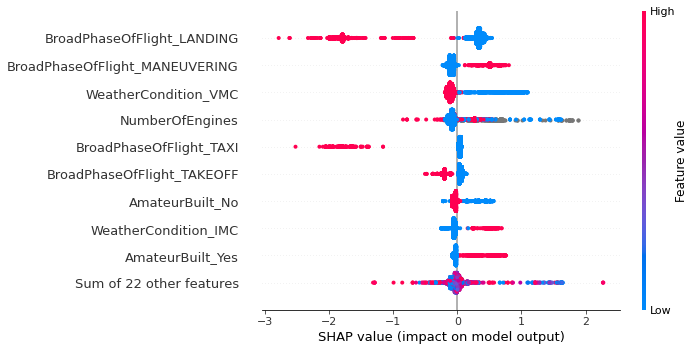

In [12]:
#XGBoost model was trained to predict whether an incident contained a fatality 
#features included 'AircraftCategory', 'AmateurBuilt', 'NumberOfEngines', 'WeatherCondition', 'BroadPhaseOfFlight'
#see shaps.ipynb
confusion_list = pickle.load(open("tmp/confusion.pkl", "rb"))
print(confusion_list, '\n\n')

#confusion matrix and shap_values saved from initial training in tmp directory
shap_values = pickle.load(open("tmp/shap_values.pkl", "rb"))
figure(figsize=(30, 30))
shap.plots.beeswarm(shap_values)

<Figure size 1080x1080 with 0 Axes>

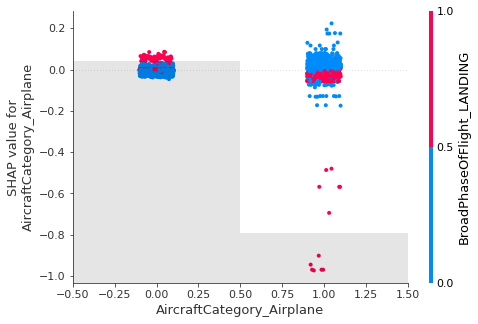

<Figure size 1080x1080 with 0 Axes>

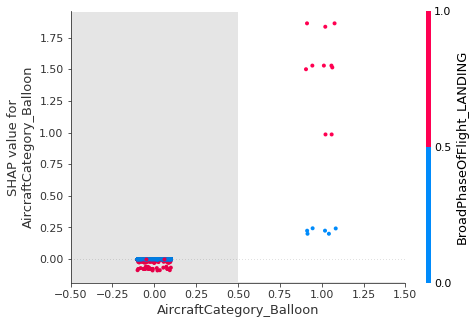

<Figure size 1080x1080 with 0 Axes>

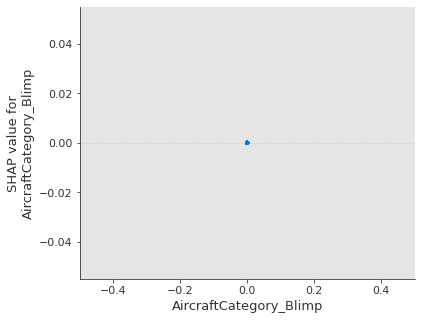

<Figure size 1080x1080 with 0 Axes>

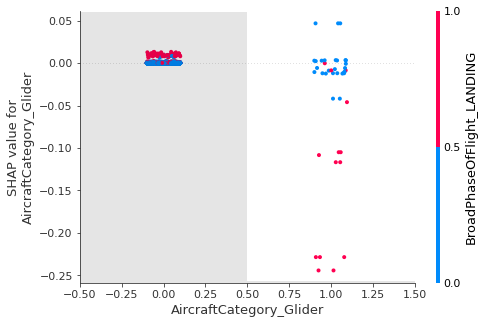

<Figure size 1080x1080 with 0 Axes>

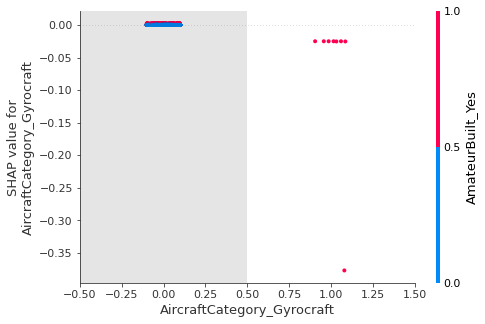

<Figure size 1080x1080 with 0 Axes>

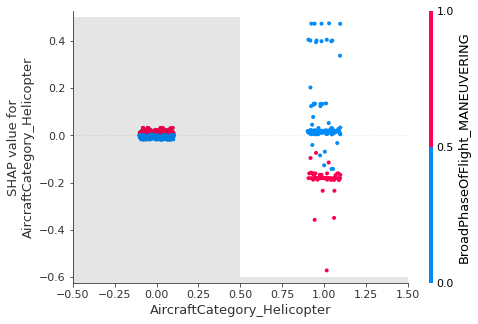

<Figure size 1080x1080 with 0 Axes>

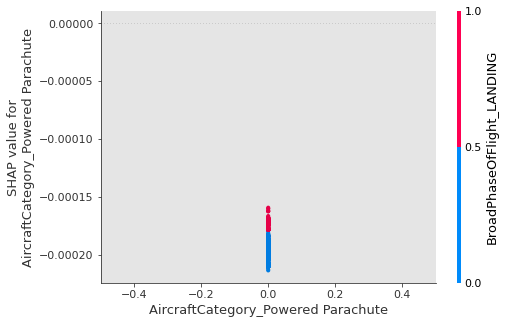

<Figure size 1080x1080 with 0 Axes>

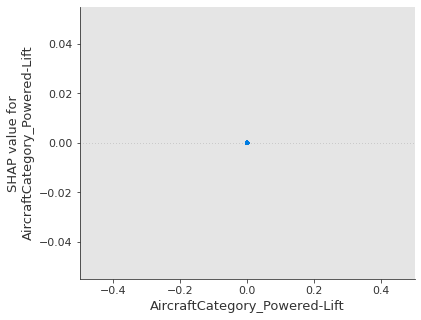

<Figure size 1080x1080 with 0 Axes>

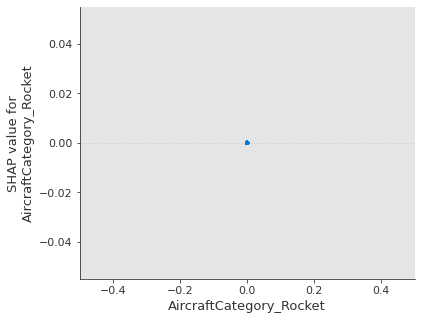

<Figure size 1080x1080 with 0 Axes>

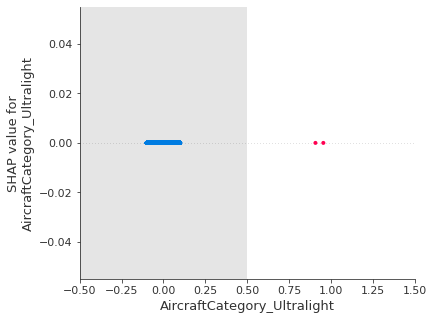

<Figure size 1080x1080 with 0 Axes>

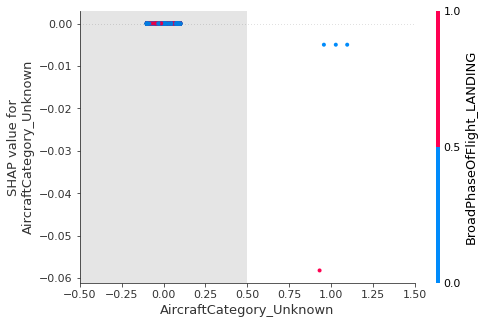

<Figure size 1080x1080 with 0 Axes>

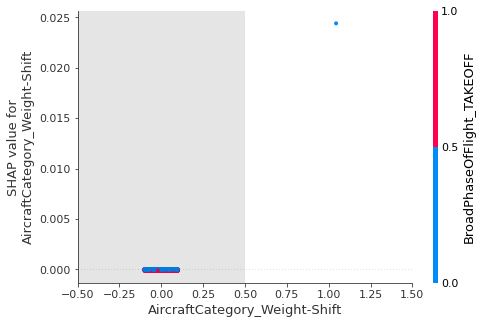

<Figure size 1080x1080 with 0 Axes>

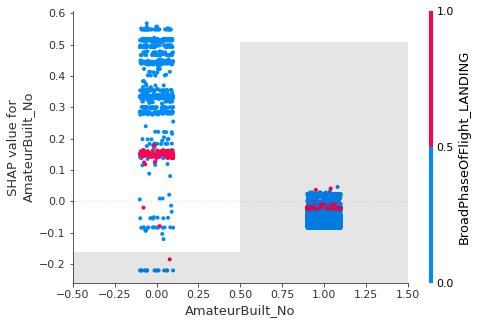

<Figure size 1080x1080 with 0 Axes>

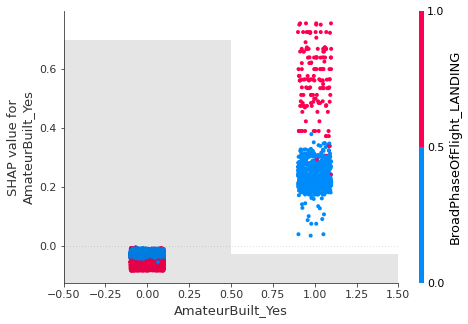

<Figure size 1080x1080 with 0 Axes>

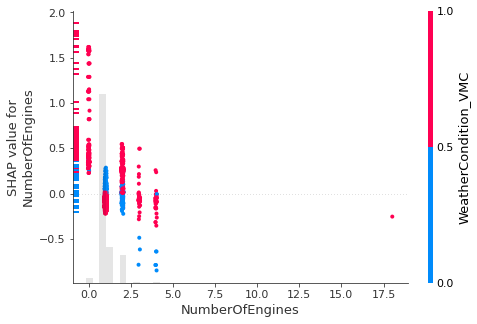

<Figure size 1080x1080 with 0 Axes>

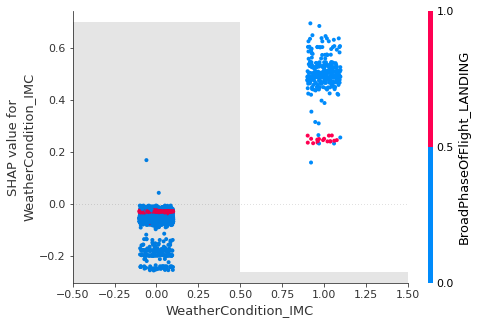

<Figure size 1080x1080 with 0 Axes>

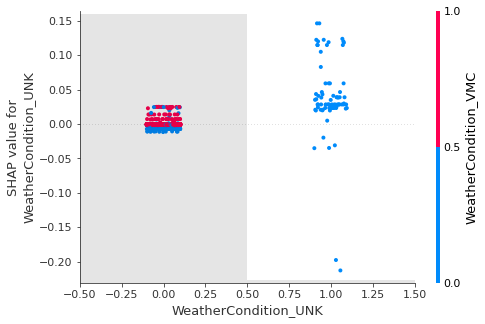

<Figure size 1080x1080 with 0 Axes>

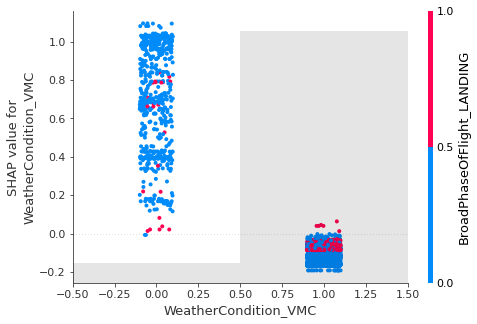

<Figure size 1080x1080 with 0 Axes>

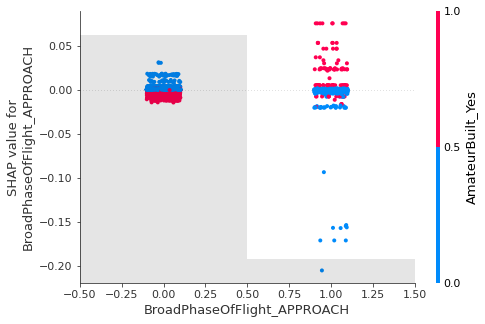

<Figure size 1080x1080 with 0 Axes>

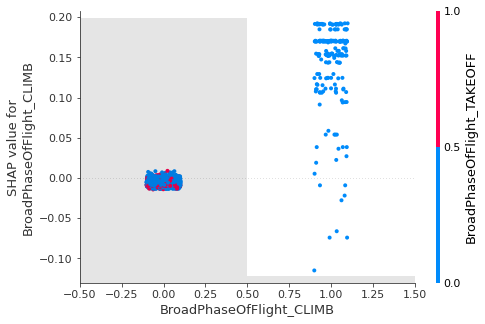

<Figure size 1080x1080 with 0 Axes>

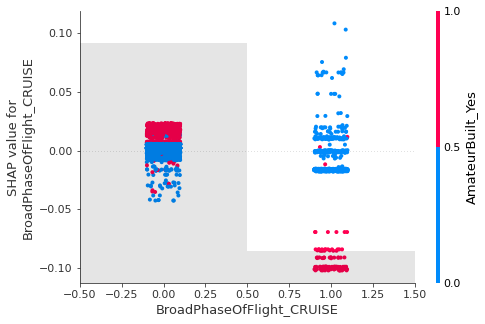

<Figure size 1080x1080 with 0 Axes>

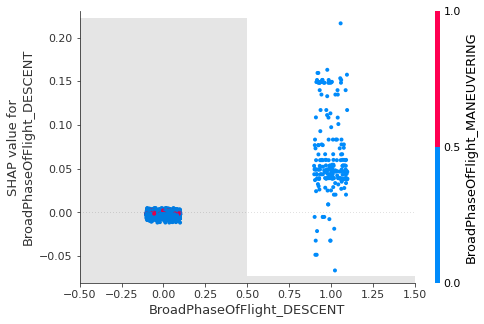

<Figure size 1080x1080 with 0 Axes>

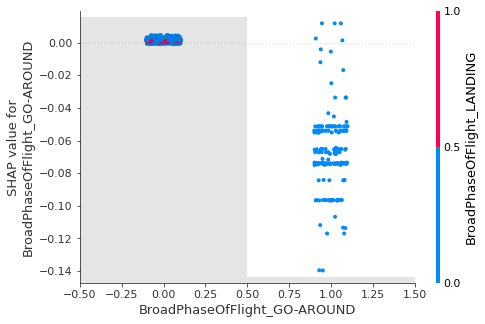

<Figure size 1080x1080 with 0 Axes>

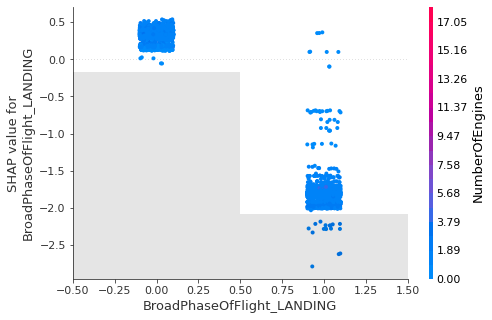

<Figure size 1080x1080 with 0 Axes>

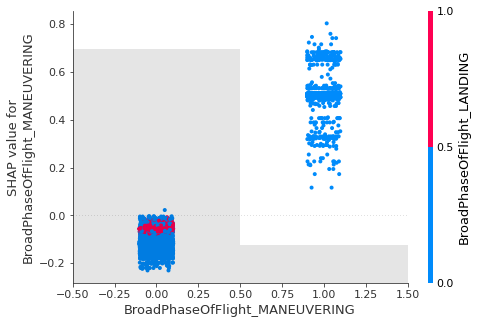

<Figure size 1080x1080 with 0 Axes>

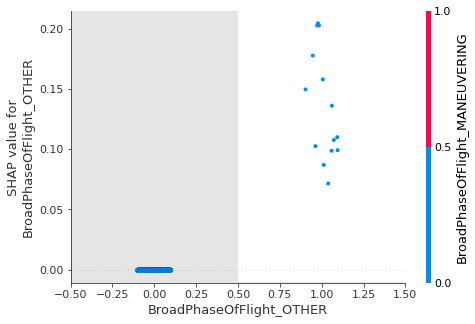

<Figure size 1080x1080 with 0 Axes>

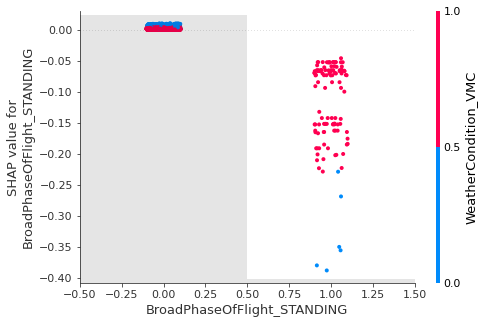

<Figure size 1080x1080 with 0 Axes>

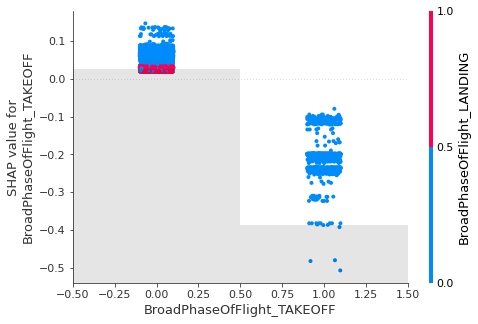

<Figure size 1080x1080 with 0 Axes>

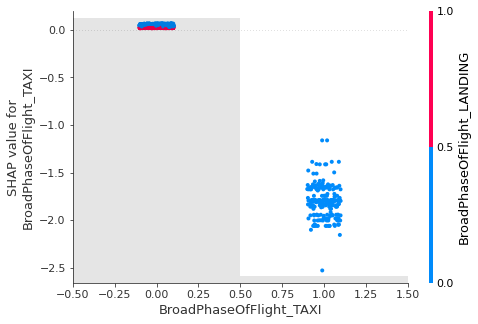

<Figure size 1080x1080 with 0 Axes>

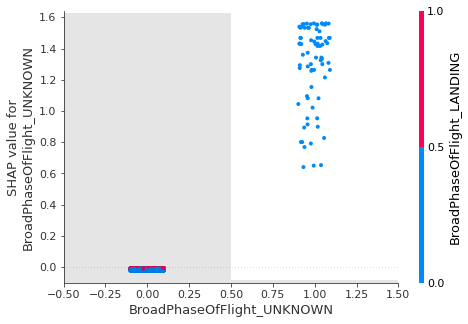

<Figure size 1080x1080 with 0 Axes>

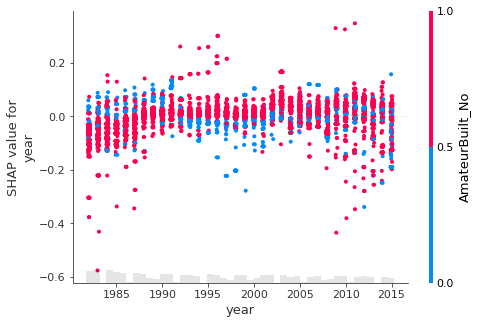

In [13]:
#prints out the most impactful feature interactions for each column
shap_values = pickle.load(open("tmp/shap_values.pkl", "rb"))
x_test = pickle.load(open("tmp/x_test_for_shaps.pkl", "rb"))

for i, column in enumerate(x_test.columns):
    figure(figsize=(15, 15))
    shap.plots.scatter(shap_values[:,column], color=shap_values)
    plt.show()

In [17]:
df['TotalFatalInjuries']

EventDate
1982-01-01    0.0
1982-01-01    0.0
1982-01-01    0.0
1982-01-01    0.0
1982-01-01    0.0
             ... 
2015-08-31    NaN
2015-09-01    NaN
NaT           NaN
NaT           NaN
NaT           2.0
Name: TotalFatalInjuries, Length: 77251, dtype: float64